In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
FOLDERNAME = 'ECE C247 Final Project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.utils.data
from sklearn.model_selection import train_test_split, KFold

In [ ]:
device = torch.device('cuda:0')

## Downloading the dataset

In [ ]:
%cd '/content/drive/MyDrive/ECE C247 Final Project/dataset'
import numpy as np
import pandas as pd
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

y_train_valid -= 769
y_test -= 769

/content/drive/MyDrive/ECE C247 Final Project/dataset


In [ ]:
print("Training/Valid data shape: {}".format(X_train_valid.shape))
print("Test data shape: {}".format(X_test.shape))
print("Training/Valid target shape: {}".format(y_train_valid.shape))
print("Test target shape: {}".format(y_test.shape))
print("Person train/valid shape: {}".format(person_train_valid.shape))
print("Person test shape: {}".format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [ ]:
s1_X_train_valid = X_train_valid[np.where(person_train_valid == 1)[0]]
s1_y_train_valid = y_train_valid[np.where(person_train_valid == 1)[0]]
s1_X_test = X_test[np.where(person_test == 1)[0]]
s1_y_test = y_test[np.where(person_test == 1)[0]]

print(s1_X_train_valid.shape, s1_y_train_valid.shape, s1_X_test.shape, s1_y_test.shape)

(236, 22, 1000) (236,) (50, 22, 1000) (50,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=10)
s1_X_train, s1_X_val, s1_y_train, s1_y_val = train_test_split(s1_X_train_valid, s1_y_train_valid, test_size=0.2, random_state=10)

In [ ]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y

In [ ]:
# X_train,y_train = data_prep(X_train,y_train,2,2,True)
# X_val,y_val = data_prep(X_val,y_val,2,2,True)
# X_test,y_test = data_prep(X_test,y_test,2,2,True)

# s1_X_train, s1_y_train = data_prep(s1_X_train, s1_y_train,2,2,True)
# s1_X_val, s1_y_val = data_prep(s1_X_val, s1_y_val,2,2,True)
# s1_X_test, s1_y_test = data_prep(s1_X_test, s1_y_test,2,2,True)

In [ ]:
X_train = np.swapaxes(X_train, 1,2)
X_val = np.swapaxes(X_val, 1,2)
X_test = np.swapaxes(X_test, 1,2)

s1_X_train = np.swapaxes(s1_X_train, 1,2)
s1_X_val = np.swapaxes(s1_X_val, 1,2)
s1_X_test = np.swapaxes(s1_X_test, 1,2)

In [ ]:
X_train = torch.from_numpy(X_train).float()
X_train = X_train[:,None,:,:]
s1_X_train = torch.from_numpy(s1_X_train).float()
s1_X_train = s1_X_train[:,None,:,:]
y_train = torch.from_numpy(y_train).long()
s1_y_train = torch.from_numpy(s1_y_train).long()

X_val = torch.from_numpy(X_val).float()
X_val = X_val[:,None,:,:]
s1_X_val = torch.from_numpy(s1_X_val).float()
s1_X_val = s1_X_val[:,None,:,:]
y_val = torch.from_numpy(y_val).long()
s1_y_val = torch.from_numpy(s1_y_val).long()

X_test = torch.from_numpy(X_test).float()
X_test = X_test[:,None,:,:]
s1_X_test = torch.from_numpy(s1_X_test).float()
s1_X_test = s1_X_test[:,None,:,:]
y_test = torch.from_numpy(y_test).long()
s1_y_test = torch.from_numpy(s1_y_test).long()

print('X train shape: {}, y train shape: {}'.format(X_train.shape, y_train.shape))
print('X validation shape: {}, y validation shape: {}'.format(X_val.shape, y_val.shape))
print('X test shape: {}, y test shape: {}'.format(X_test.shape, y_test.shape))

X train shape: torch.Size([1692, 1, 1000, 22]), y train shape: torch.Size([1692])
X validation shape: torch.Size([423, 1, 1000, 22]), y validation shape: torch.Size([423])
X test shape: torch.Size([443, 1, 1000, 22]), y test shape: torch.Size([443])


In [ ]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

s1_train_dataset = torch.utils.data.TensorDataset(s1_X_train, s1_y_train)
s1_val_dataset = torch.utils.data.TensorDataset(s1_X_val, s1_y_val)
s1_test_dataset = torch.utils.data.TensorDataset(s1_X_test, s1_y_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

s1_train_dataloader = torch.utils.data.DataLoader(s1_train_dataset, batch_size=32, shuffle=True)
s1_val_dataloader = torch.utils.data.DataLoader(s1_val_dataset, batch_size=32, shuffle=True)
s1_test_dataloader = torch.utils.data.DataLoader(s1_test_dataset, batch_size=32, shuffle=True)

## LSTM

architecture inspiration taken from cnvrg.io

In [ ]:
class LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
      super(LSTM, self).__init__()
      self.num_classes = num_classes #number of classes
      self.num_layers = num_layers #number of layers
      self.input_size = input_size #input size
      self.hidden_size = hidden_size #hidden state
      self.seq_length = seq_length #sequence length

      self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                        num_layers=num_layers, batch_first=True, dropout=0.4) 
      
      self.fc = nn.Sequential(
            nn.Linear(100, 64),
            nn.BatchNorm1d(num_features=64, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(num_features=32, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(32, num_classes)
        )
    
  def forward(self,x):
      h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).requires_grad_() #hidden state
      c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).requires_grad_()
      # Propagate input through LSTM
      out, (hn, cn) = self.lstm(x)
      out = self.fc(out[:, -1, :])
      return out

In [ ]:
# define hyperparameters
learning_rate = 1e-3

input_size = 22
hidden_size = 100
num_layers = 2

num_classes = 4
lstm1 = LSTM(num_classes=num_classes, input_size=input_size, hidden_size=hidden_size, 
             num_layers=num_layers, seq_length=X_train_valid.shape[2]).to(device)
CELoss_criterion = torch.nn.CrossEntropyLoss()
Adam_optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [ ]:
#!pip install pytorch_model_summary
from pytorch_model_summary import summary
print(summary(lstm1, torch.zeros(1, 250, 22).to(device), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
            LSTM-1        [1, 250, 22]         130,400         130,400
          Linear-2            [1, 100]           6,464           6,464
     BatchNorm1d-3             [1, 64]             128             128
            ReLU-4             [1, 64]               0               0
         Dropout-5             [1, 64]               0               0
          Linear-6             [1, 64]           2,080           2,080
     BatchNorm1d-7             [1, 32]              64              64
            ReLU-8             [1, 32]               0               0
          Linear-9             [1, 32]             132             132
Total params: 139,268
Trainable params: 139,268
Non-trainable params: 0
-----------------------------------------------------------------------


## Training LSTM Model

In [ ]:
def train(model, optimizer, criterion, dataloader, epoch, num_epochs):
  
  model.train()
  
  for i, (input, labels) in enumerate(dataloader):
      input, labels = input.to(device), labels.to(device)
      # Load input as a torch tensor with gradient accumulation abilities
      # print(input.shape)
      input = input.view(-1, input.shape[2], input.shape[3]).requires_grad_()
      # print(input.shape)

      # Clear gradients w.r.t. parameters
      optimizer.zero_grad()

      # Forward pass to get output/logits
      outputs = model(input)

      # Calculate Loss: softmax --> cross entropy loss
      loss = criterion(outputs, labels)
      
      # Getting gradients w.r.t. parameters
      loss.backward()

      # Updating parameters
      optimizer.step()

      # Print Training Loss
      if i%50 == 0:
        print('Epoch {}/{} \tTraining Loss: {}'.format(epoch+1, num_epochs, loss.data))

  return model

In [ ]:
def predict(model, dataloader, mode):
  
  model.eval()

  correct = 0
  total = 0
  # Iterate through test dataset
  for input, labels in dataloader:
      input, labels = input.to(device), labels.to(device)
      # Resize images
      input = input.view(-1, input.shape[2], input.shape[3])

      # Forward pass only to get logits/output
      outputs = model(input)

      # Get predictions from the maximum value
      _, predicted = torch.max(outputs.data, 1)

      # Total number of labels
      total += labels.size(0)

      # Total correct predictions
      correct += (predicted == labels).sum()

  accuracy = 100 * correct / total
  print('{} Accuracy: {}%'.format(mode, accuracy))
  
  return accuracy, model

In [ ]:
def train_and_predict(model, optimizer, criterion, num_epochs, train_dataloader, val_dataloader):

  train_accs = []
  val_accs = []
  test_accs = []
  train_dataloader = train_dataloader
  val_dataloader = val_dataloader

  for epoch in range(num_epochs):
    
    model = train(model=model, optimizer=optimizer, criterion=criterion, dataloader=train_dataloader, epoch=epoch, num_epochs=num_epochs)

    # Training Accuracy
    train_acc, __ = predict(model=model, dataloader=train_dataloader, mode='Training')
    train_accs.append(train_acc)

    # Validation Accuracy
    val_acc, __ = predict(model=model, dataloader=val_dataloader, mode='Validation')
    val_accs.append(val_acc)

    # # Test Accuracy
    # test_acc, __ = predict(model=model, dataloader=test_dataloader)
    # test_accs.append(test_acc)

  return train_accs, val_accs #, test_accs

In [ ]:
train_accs, val_accs = train_and_predict(model=lstm1, optimizer=Adam_optimizer, criterion=CELoss_criterion, num_epochs=100, 
                                         train_dataloader=train_dataloader, val_dataloader=val_dataloader)

Epoch 1/100 	Training Loss: 1.3906700611114502
Epoch 1/100 	Training Loss: 1.354216456413269
Training Accuracy: 41.78487014770508%
Validation Accuracy: 24.822694778442383%
Epoch 2/100 	Training Loss: 1.1898728609085083
Epoch 2/100 	Training Loss: 1.4332715272903442
Training Accuracy: 42.84870147705078%
Validation Accuracy: 26.241134643554688%
Epoch 3/100 	Training Loss: 1.2259186506271362
Epoch 3/100 	Training Loss: 1.4112286567687988
Training Accuracy: 46.572105407714844%
Validation Accuracy: 22.931442260742188%
Epoch 4/100 	Training Loss: 1.2014631032943726
Epoch 4/100 	Training Loss: 1.2159391641616821
Training Accuracy: 48.40425491333008%
Validation Accuracy: 24.113475799560547%
Epoch 5/100 	Training Loss: 1.268478274345398
Epoch 5/100 	Training Loss: 1.2923007011413574
Training Accuracy: 51.59574508666992%
Validation Accuracy: 23.167848587036133%
Epoch 6/100 	Training Loss: 1.255422830581665
Epoch 6/100 	Training Loss: 1.3560874462127686
Training Accuracy: 50.118202209472656%
Vali

In [ ]:
train_accs_1, val_accs_1 = train_and_predict(model=lstm1, optimizer=Adam_optimizer, criterion=CELoss_criterion, num_epochs=100, 
                                             train_dataloader=s1_train_dataloader, val_dataloader=s1_val_dataloader)

Epoch 1/100 	Training Loss: 0.6027045249938965
Training Accuracy: 87.76595306396484%
Validation Accuracy: 77.08333587646484%
Epoch 2/100 	Training Loss: 1.0375028848648071
Training Accuracy: 92.55319213867188%
Validation Accuracy: 77.08333587646484%
Epoch 3/100 	Training Loss: 0.3647008240222931
Training Accuracy: 94.68084716796875%
Validation Accuracy: 79.16667175292969%
Epoch 4/100 	Training Loss: 0.3781101405620575
Training Accuracy: 96.80850982666016%
Validation Accuracy: 79.16667175292969%
Epoch 5/100 	Training Loss: 0.1303621381521225
Training Accuracy: 98.93616485595703%
Validation Accuracy: 77.08333587646484%
Epoch 6/100 	Training Loss: 0.07887998968362808
Training Accuracy: 99.46807861328125%
Validation Accuracy: 77.08333587646484%
Epoch 7/100 	Training Loss: 0.06883543729782104
Training Accuracy: 100.0%
Validation Accuracy: 75.0%
Epoch 8/100 	Training Loss: 0.04010356217622757
Training Accuracy: 100.0%
Validation Accuracy: 77.08333587646484%
Epoch 9/100 	Training Loss: 0.0716

In [ ]:
print('Highest Training Accuracy: {}%'.format(max(train_accs)))
print('Highest Validation Accuracy: {}%'.format(max(val_accs)))

Highest Training Accuracy: 100.0%
Highest Validation Accuracy: 30.260047912597656%


In [ ]:
test_acc, __ = predict(model=lstm1, dataloader=test_dataloader, mode='Test')

Test Accuracy: 27.313770294189453%


In [ ]:
print('Subject 1 Highest Training Accuracy: {}%'.format(max(train_accs_1)))
print('Subject 1 Highest Validation Accuracy: {}%'.format(max(val_accs_1)))

Subject 1 Highest Training Accuracy: 100.0%
Subject 1 Highest Validation Accuracy: 79.16667175292969%


In [ ]:
test_acc_1, __ = predict(model=lstm1, dataloader=s1_test_dataloader, mode='Test')

Test Accuracy: 20.0%


In [ ]:
train_accs_np = [int(i) for i in train_accs]
val_accs_np = [int(i) for i in val_accs]

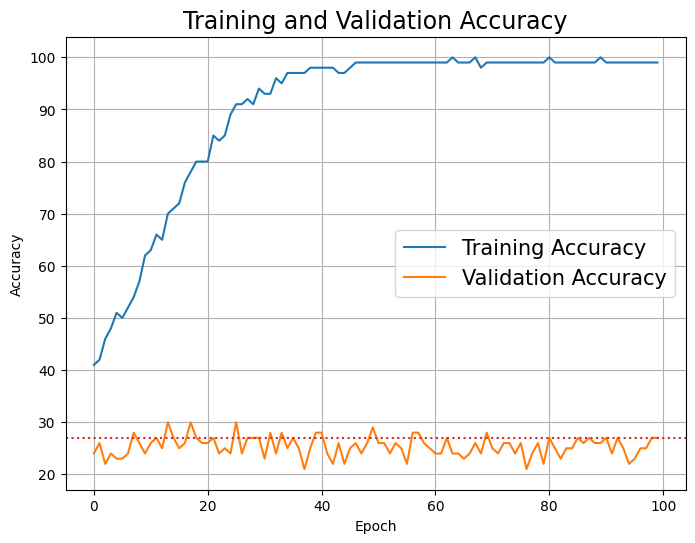

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.plot(range(100), train_accs_np, c='tab:blue', label='Training Accuracy')
ax.plot(range(100), val_accs_np, c='tab:orange', label='Validation Accuracy')
ax.axhline(y=int(test_acc), color='tab:red', linestyle='dotted')
ax.set_xlabel('Epoch', fontsize='10')
ax.set_ylabel('Accuracy', fontsize='10')
ax.set_title('Training and Validation Accuracy', fontsize='17')
ax.grid()
ax.legend(fontsize='15')
plt.show()